# Environment Set-up

In [17]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install wordcloud

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
re.__version__
import nltk
import html
import unicodedata
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

Requirement already up-to-date: spacy in c:\users\wzzz0\anaconda3\lib\site-packages (2.3.3)
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Part 1. Data Cleaning

## Procedure

>- **Remove unknown characters including \\n, \\n\\n, b' and b" :** '\\n' always refers to the character to start a new line. These characters are not important, so I just removed them.
>- **Remove html tags and attributes:** I used re.compile and sub function to remove html tags and attributes.
>- **Replace html character codes with ASCII equivalent:** The unicode characters in the tweets are normalized by 'NFKD', which means all compatibility characters would be  replaced with their equivalents, then transferred to ASCII equivalent and decoded into normal strings again.
>- **Remove urls:** I used re.sub function to replace ulrs with a space.
>- **Convert characters into lowercase:** I defined a function which combines both url removal function and lowercase conversion function.
>- **Remove retweet:** There are some expressions like 'RT' which implies retweet. So I removed them.
>- **Remove emoji:** I used regular expression to remove emojis since they have similar format.
>- **Remove some punctuations:** Here I removed most of the punctuations, including the username handle@. But I did't remove usernames since they might contain usenames like 'realDonaldTrump' and 'JoeBiden' which could be used to determing the political parties.
>- **Remove stopwords and lemmatize words:** I imported the stop_words_edited.txt file, which I removed some negative words from original stop_words.txt file. And I also lemmatized the words by using 'token.lemma_'. i.e., after lemmatization the word 'dogs' would be converted to 'dog'.
>- **Replace multiple spaces with a single space:** After the data cleaning steps above, there might be multiple spaces between two words, thus I just replaced them into a single space.

## 1. Clean US_Elections_2020 Dataset

In [18]:
tweets=pd.read_csv('US_Elections_2020.csv')
tweets.head()

,text,sentiment,negative_reason
0,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19
1,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others
2,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19
3,b'Every 107 seconds an American is dying from ...,1,NaN
4,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN


### Define Functions to Clean the Data

In [19]:
#remove html tags and attributes
def remove_tag(text):
    tag=re.compile(r'<[^>]+>')
    return tag.sub(' ',text)
   

#replace html characters with ascii code equivalent
def html_convert(text):    
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8')
    return text

#remove URLs and convert all characters into lowercase
def url_lower(s):
    s=re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', s)
    s=s.lower()
    return s

#remove stopwords, and lemmatize words
with open("stop_words_edited.txt") as f:      
 stop_word = f.read().splitlines()    # Here I edited the stop_words.txt file, words like "don't",'no',"shouldn't","neither" were not considered as stop words.
pd.DataFrame(stop_word).to_csv("stop_words_edited.txt",index=False)    #save the text file to the directory using this code

def stopword(text):
    
    doc=nlp(text,disable=['ner','parser'])              
    lemmas = [token.lemma_ for token in doc]           
    a_lemmas=[lemma for lemma in lemmas if lemma not in stop_word and lemma !='-pron-' and lemma !='-PRON-']     
    return ' '.join(a_lemmas)

#remove some punctuations
def pun_remove(text):
    punctuations='''!()[]{};:"/\,@.+-?#$%^*_~'''    
    for char in text:
       if (char in punctuations):
          text=text.replace(char," ")
    return text

# remove retweet
def retweet(text):
    text = re.sub(r'\brt\b', '', text)
    return text

#remove emoji
def remove_emoji(text):
    emoji = re.compile(r'\\[x][a-z\d]{2}')
    text = re.sub(emoji,'', text)
    return text

# replace multiple spaces with a single space
def space(text):    
    text = re.sub(r'\s+', ' ', text)
    return text

#remove character \\n \\n\\n and b',b" characters
def remove_b_n(text):
    text=text.replace("\\n\\n"," ")
    text=text.replace("\\n"," ")
    text=text.replace("\n"," ")
    text=text.replace("b'"," ")
    text=text.replace('b"'," ")
    return text


### Apply These Functions to 'text' in the Dataset

In [20]:
tweets['text']=tweets['text'].apply(remove_b_n)

In [21]:
tweets['text']=tweets['text'].apply(remove_tag)
tweets['text']=tweets['text'].apply(html_convert)
tweets['text']=tweets['text'].apply(url_lower)
tweets['text']=tweets['text'].apply(retweet)
tweets['text']=tweets['text'].apply(remove_emoji)

In [22]:
tweets['text']=tweets['text'].apply(pun_remove)

In [23]:
tweets['text']=tweets['text'].apply(stopword)

In [24]:
tweets['text']=tweets['text'].apply(space)

### Dataset After Cleaning

In [25]:
tweets.head()    

,text,sentiment,negative_reason
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19
1,suec00k lord sumption launch recovery initiat...,0,others
2,walidphares uber timing biden advisor pressur...,0,covid19
3,107 second american die trumpvirus donaldtrum...,1,NaN
4,thewebbix democrats embrace diversityandinclu...,1,NaN


## 2. Clean Sentiment_Analysis Dataset

In [5]:
sentiment_original=pd.read_csv('sentiment_analysis.csv')
sentiment_original.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


### Stratified Random Sampling: Randomly Choose 20% of the Dataset Based on Two Strata

Since the size of the dataset is too large, I randomly chose 20% data points from the original dataset, grouped by 'label'(0 and 1). Thus the proportion of 'label1' to 'label0' is not changed.

In [6]:
sentiment= sentiment_original.groupby('label').apply(lambda x: x.sample(frac=0.2))
sentiment

ID                                               text  \
label                                                                           
0     304303  7.992100e+17  about to get some shit done https://t.co/pooSg...   
      242207  7.968660e+17    damn :/// @PatrickPitts https://t.co/fBKdXy8yVm   
      284190  7.985170e+17  @minhunniee @minhunniee 4.6m dl this year rele...   
      410894  8.028700e+17  Fidel Castro: Justin Trudeau ridiculed over pr...   
      403255  8.025590e+17  Not everybody gonna like ya shit right 😂😂 much...   
...                    ...                                                ...   
1     85538   7.693070e+17  RT @TheAnimalVines: Happy #NationalDogDay http...   
      67069   7.691340e+17  RT @blondemel47: That's a wrap! #Damsel. Some ...   
      26289   7.684860e+17  RT @evanjaquez: My heart: Omg that person is s...   
      177519  7.836060e+17  Messed up a bit on this song, but its all good...   
      494115  7.829280e+17  ✨????Let's #chillout together. #Nothing but go...   

              label  
label                
0     304303      0  
      242207      0  
      284190      0  
      410894      0  
      403255      0  
...             ...  
1     85538       1  
      67069       1  
      26289       1  
      177519      1  
      494115      1  

[110078 rows x 3 columns]

In [7]:
#shuffle data

sentiment=sentiment.sample(frac=1).reset_index(drop=True)
sentiment

,ID,text,label
0,7.997610e+17,a not absolutely terrible sombra game #PS4sha...,0
1,7.967330e+17,Happy Birthday! I love you sir 💖 https://t.co/...,1
2,7.690290e+17,RT @MuslimsHillary: Stop violence against #Mus...,0
3,7.844320e+17,My dad is in Iceland rn &amp; I'm really sad i...,0
4,7.692340e+17,RT @zenkmm: Love fr music❤️ fr Life #ALDUBLOL...,1
...,...,...,...
110073,7.803850e+17,"Found a Transponder Snail!Giants, sea monsters...",1
110074,8.030930e+17,look at the last comment. ariana's goats came ...,0
110075,7.686230e+17,RT @AnnalisaParent: #Writing doesn't have to b...,1
110076,7.971050e+17,Love seeing this every time I swipe right! #IR...,1


### Apply the Defined Functions above to the 'text' in the Sentiment Dataset

In [8]:
#Since the difine functions for cleaning can also be applied into this data set, we just apply the functions.

sentiment['text']=sentiment['text'].apply(remove_b_n)

In [9]:
sentiment['text']=sentiment['text'].apply(remove_tag)
sentiment['text']=sentiment['text'].apply(html_convert)
sentiment['text']=sentiment['text'].apply(url_lower)
sentiment['text']=sentiment['text'].apply(retweet)
sentiment['text']=sentiment['text'].apply(remove_emoji)

In [10]:
sentiment['text']=sentiment['text'].apply(pun_remove)

In [11]:
sentiment['text']=sentiment['text'].apply(stopword)

In [12]:
sentiment['text']=sentiment['text'].apply(space)

### Dataset After Cleaning

In [13]:
sentiment.head()

,ID,text,label
0,7.997610e+17,not absolutely terrible sombra game ps4share,0
1,7.967330e+17,happy birthday love sir,1
2,7.690290e+17,muslimshillary violence muslims hate american...,0
3,7.844320e+17,dad iceland rn & sad not killin selfie game mike,0
4,7.692340e+17,zenkmm love fr music fr life aldublolasinconc...,1


# Part 2. Exploratory analysis

### Procedure

>  ### US_Election_2020 Dataset
>- **Determine the distribution of the political parties on twitter**
>- **Counts plot for different political parties**
>- **Visualization of sentiment labels distribution of different political parties in twitter**
>- **Bonus Part 1.1 - Word cloud for i) all text in twitter ii) text related to two different political parties in twitter**

>  ### Sentiment_analysis Dataset
>- **Pie Chart of the the distribution of sentiment labels**
>- **Bonus Part 1.2 - Word cloud for all tweets text**

### Explanation

>- **Political affiliations:** For Republican Party, besied Donald Trump, hashtags like #moscowmitch, #votered, #redwave, and #4moreyears all indicate Republican/Conservative Party. And the person Boris Johnson is also a conservative leader whose twitter account is @BorisJohnson.
>- **Democratic affiliations:** For Democratic Party, besides Joe Biden and Komal Hharris(whose twitter account is @KamalaHarris),the hashtags like #voteblue and #bluewave also indicate Democratic Party.
>- **Determine the political party:** For this part, I used str.contains() function.i.e, words like 'realdonaldtrump' is considered to be related to Republican Party since it contains trump(/donald).
>- **Word cloud:** A word cloud is a visualization of data, in which words are shown in varying sizes depending on how often they appear in your data. The more frequently the words appear, the bigger the size of the word is.

### Discussion and Conclusion

>-  **What can you say about the distribution of the political affiliations of the tweets?**
      1.The number of the tweets relevant to only Democratic Party is 548.
      The number of the tweets relevant to only Republican Party is 672.
      The number of the tweets that relevant to Both Parties is 277.
      And combined with the frequency bar plot, we can see that the number of the tweets relevant to Democratic Party is lower than that of Republican Party.
      2.From the frequency of sentiment label plot, we can see that for Democratic Party,there are much more positive tweets than negative ones. While for Republican Party, there are much more negative tweets. And for the tweets which mention both of the parties, the number of positive tweets are roughly the same with the negative ones. Thus we can conclude there are more supporters for Democratic Party.

## 1.Distribution of the political affiliations of the tweets

### Calculate the counts of the political affiliations on twitter

In [34]:
#determine the political party

republican=['trump','donald','borisjohnson','moscowmitch','conservative','republican','votered','redwave','4moreyears']
democratic=['biden','joe','komalaharris','democrat','voteblue','bluewave']
text=tweets['text']
tweets['Party']='N'
count_both=0
count_demo=0
count_repu=0
count_others=0
for i in range(len(text)):
  if (text.str.contains('|'.join(republican))[i]==True) & (text.str.contains('|'.join(democratic))[i]==True): 
        tweets['Party'][i]='Both'
        count_both=count_both+1
  elif (text.str.contains('|'.join(republican))[i]==True) & (text.str.contains('&'.join(democratic))[i]==False):     #'Republican Party' means tweets only relevant to Republican Party
        tweets['Party'][i]='Republican Party'
        count_repu=count_repu+1
  elif (text.str.contains('&'.join(republican))[i]==False) & (text.str.contains('|'.join(democratic))[i]==True):     #'Democratic Party' means tweets only relevant to Democratic Party
        tweets['Party'][i]='Democratic Party'                                  
        count_demo=count_demo+1
  else:
       tweets['Party'][i]='Others'
       count_others=count_others+1
    
tweets['Party']

0       Democratic Party
1                 Others
2       Democratic Party
3                   Both
4       Democratic Party
              ...       
2547              Others
2548    Democratic Party
2549    Republican Party
2550    Democratic Party
2551              Others
Name: Party, Length: 2552, dtype: object

In [35]:
tweets[tweets['Party']=='Democratic Party']

,text,sentiment,negative_reason,Prediction,Party
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,0,Democratic Party
2,walidphares uber timing biden advisor pressur...,0,covid19,0,Democratic Party
4,thewebbix democrats embrace diversityandinclu...,1,NaN,1,Democratic Party
10,breakingnews october catsoftwitter dogsoftwit...,0,corruption,0,Democratic Party
15,watch happen 4 57 dethippiechick 's broadcast...,1,NaN,1,Democratic Party
...,...,...,...,...,...
2524,trunalimunumaprzure bidenharris2020 ',1,NaN,1,Democratic Party
2525,azynnn tear voteblue ',0,others,0,Democratic Party
2531,foxnews broadcast joebiden rally st paul cnn ...,1,NaN,1,Democratic Party
2548,nowthisnew deliver today montgomery county pa...,1,NaN,1,Democratic Party


In [36]:
tweets[tweets['Party']=='Republican Party']

,text,sentiment,negative_reason,Prediction,Party
5,accelerate & rise americans kill trumpvirus,0,discrimination,0,Republican Party
6,realdonaldtrump 961 dead americans day 240 ti...,0,discrimination,0,Republican Party
8,charliekirk11 reason realdonaldtrump 3 rally ...,0,corruption,0,Republican Party
11,realdonaldtrump ur campaign pay people rig me...,0,crime,0,Republican Party
13,realdonaldtrump maga disgusting sunday school ',0,discrimination,0,Republican Party
...,...,...,...,...,...
2528,not poll trump win landslide victory paint ma...,1,NaN,1,Republican Party
2534,realdonaldtrump kill american dream covid cas...,0,corruption,0,Republican Party
2539,trump force hold rally front small socially d...,0,discrimination,0,Republican Party
2540,trumpsdeadlysin unlimited covid 30 000 lie fa...,0,others,0,Republican Party


In [37]:
tweets[tweets['Party']=='Both']

,text,sentiment,negative_reason,Prediction,Party
3,107 second american die trumpvirus donaldtrum...,1,NaN,1,Both
9,joebarri concern hunterbiden trump ass kisser...,0,covid19,0,Both
16,joebiden call trump supporter ugly shame day ...,0,corruption,0,Both
18,realdonaldtrump will glad listen ass voice bi...,0,covid19,0,Both
62,rwtrollpatrol joebiden watch great film meida...,1,NaN,1,Both
...,...,...,...,...,...
2494,mike pence realdonaldtrump america not afford...,0,discrimination,0,Both
2502,kokomothegreat realdonaldtrump healthcare pro...,0,crime,0,Both
2526,biden lead trump poll exist pollster force tr...,0,discrimination,0,Both
2532,iaco poll wishful thinking democrats fake new...,0,corruption,0,Both


In [38]:
# count of different parties 

print('The number of the tweets that identify only Democratic Party is: ', count_demo)
print('The number of the tweets that identify only Republican Party is: ', count_repu)
print('The number of the tweets that identify Both Parties is: ', count_both)
print('The number of the tweets that identify others is: ', count_others)

The number of the tweets that identify only Democratic Party is:  548
The number of the tweets that identify only Republican Party is:  672
The number of the tweets that identify Both Parties is:  277
The number of the tweets that identify others is:  1055


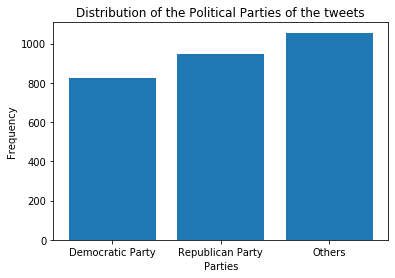

In [265]:
### frequency distribution bar plot

import matplotlib
import matplotlib.pyplot as plt

party=['Democratic Party','Republican Party','Others']
freq=[count_demo+count_both,count_repu+count_both,count_others]  #I added "both" to the two groups "Democratic Party" and "Republican Party" here to see the general frequency distribution
plt.bar(party, freq)
plt.title("Distribution of the Political Parties of the tweets")
plt.xlabel("Parties")
plt.ylabel("Frequency")

plt.show()

#### From the frequency distribution bar plot, we can see that the number of the tweets relevant to Republican Party is a little bit higher that that of Democratic Party. And from the data above, there are 273 tweets talking about both parties.

## 2.Visualization

## 2.1 2020 US Election dataset

### Distribution of sentiment labels for different political affiliations of the tweets

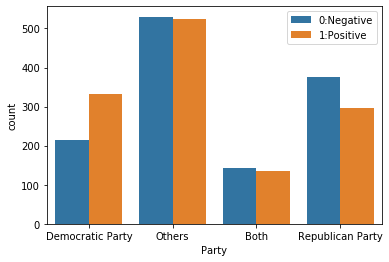

In [266]:
ax = sns.countplot(x='Party', hue='sentiment', data=tweets)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['0:Negative','1:Positive'], bbox_to_anchor=(1,1))
plt.show();

### Since sentiment'0' is negative, sentiment'1' is positive, from the plot, we can see that for Democratic Party,there are much more positive tweets than negative ones. While for Republican Party, there are much more negative tweets than positive ones. And for the tweets which mention both of the parties, the number of positive tweets are roughly the same with the negative ones. 

## *Bonus Part 1.1: Word Cloud for Different Political Parties

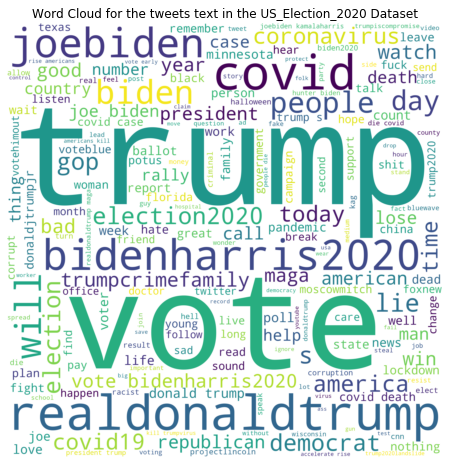

In [267]:
# wordcloud for all texts of the tweets(text cleaned already)
words=''
for val in tweets['text']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text in the US_Election_2020 Dataset')
plt.show()

### From the wordcloud above, we can see that the most frequent words on twitter are 'trump' and 'vote'. And words like 'biden','joebiden' also appear frequently, though less frequently than 'trump'. And people also talk a lot about 'covid', 'coronavirus' and 'election'

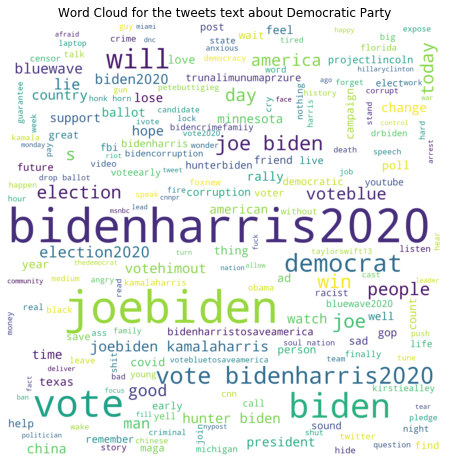

In [268]:
#wordcloud for tweets only about Democratic Party

words=''
for val in tweets['text'][tweets['Party']=='Democratic Party']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text about Democratic Party')
plt.show()

### We can see from the word cloud about Democratic Party, besides words relative to 'biden', the positive words like 'love','good','win','support'  appear frequently, but there are also negative words like 'shit', 'lie' etc.

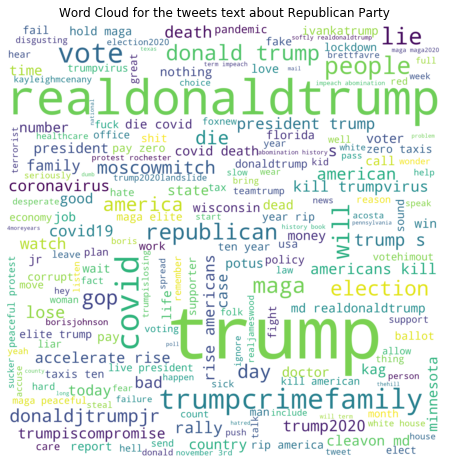

In [269]:
#wordcloud for tweets only about Republican Party

words=''
for val in tweets['text'][tweets['Party']=='Republican Party']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (8, 8))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text about Republican Party')
plt.show()

### We can see from the word cloud of Republican Party that words about 'trump' appear most frequently. Besides, there are a lot of negative words like 'die', 'lose', 'death', 'fail', 'lie', 'trumpcrimefamily' and so on. Negative words are much more than positive words.

## 2.2 Sentiment Analysis Dataset

### Pie chart of the frequency distribution of sentiment labels

array([<AxesSubplot:ylabel='ID'>], dtype=object)

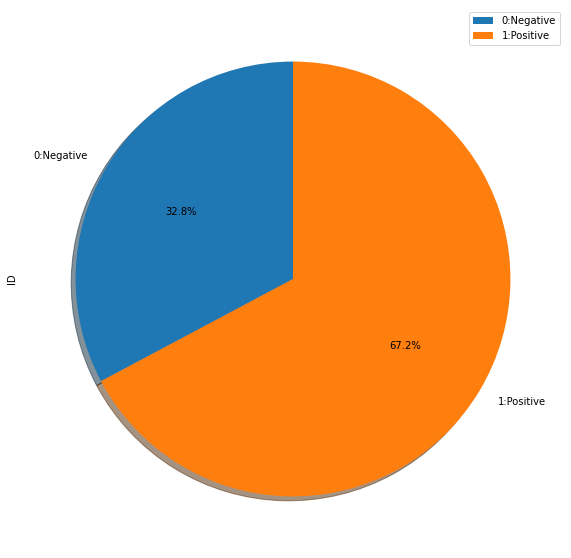

In [27]:
labels='0:Negative','1:Positive'
sentiment.groupby(['label']).sum().plot(kind='pie', subplots=True, labels=labels,shadow = True,startangle=90,figsize=(15,10), autopct='%1.1f%%')

#### We can see that the tweets with label'1' account for 67.2%, and the tweets with label'0' account for 32.8% . Label 1 is positive, and label 0 is negative.

## *Bonus Part 1.2: Word Cloud Visualization

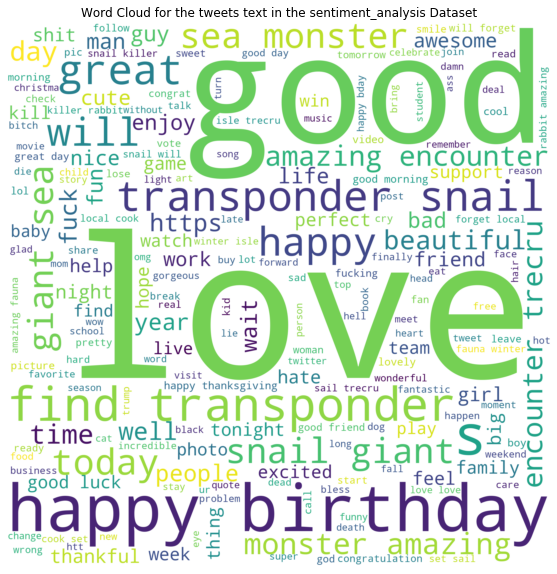

In [29]:
words=''
for val in sentiment['text']: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    words += " ".join(tokens)+" "
    
cloud=WordCloud(width = 2500, height = 2500,background_color='white',).generate(words)
plt.figure(figsize = (10, 10))
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for the tweets text in the sentiment_analysis Dataset')
plt.show()

# Part 3. Model Preparation

### Procedure
>- **Text vectorization using two features:1) Bag of Words 2) TF-IDF**
>- **Split generic data into training data and test data**

### Explanation
>- In this step, I selected the max_feature to be 5000, in case of losing important information.
>- When we split data randomly into training data and test data, we should do random sampling based on two strata:label 0 and label 1.


## 1.Text Vectorization

### 1.1 Bag-of-Words

In [63]:
vect1=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(sentiment.text)
vect1_=vect1.transform(sentiment.text)
vect1_

<110078x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 537110 stored elements in Compressed Sparse Row format>

### 1.2 TF-IDF

In [98]:
vect2=TfidfVectorizer(max_features=5000,token_pattern=r'\w+').fit(sentiment.text)
vect2_=vect2.transform(sentiment.text)
vect2_

<110078x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 537110 stored elements in Compressed Sparse Row format>

## 2. Split Data into Training Data and Test Data

### 2.1 Split data for bag-of-words

In [65]:
y1=sentiment.label
X1=vect1_
X_train1,X_test1,y_train1,y_test1=train_test_split(X1,y1,test_size=0.3,random_state=0,stratify=sentiment['label'])


### 2.2 Split data for TF-IDF

In [66]:
y2=sentiment.label
X2=vect2_
X_train2,X_test2,y_train2,y_test2=train_test_split(X2,y2,test_size=0.3,random_state=0,stratify=sentiment['label'])

# Part 4. Model Implementation and Tuning

### Procedure

>- **Model traning:** In this step, I trained the data using seven models based on two features including Bag of Word and TF-IDF.
>- **Model evaluation on US election data:** I applied the best model I got from the former model training step in US election data. The best model is the model with highest test accuracy. And I calculated the accuracy.
>- **Visualization of the true sentiment vs. predicted sentiment:**
>- **Hyperparameter Tuning by 10-fold Cross-Validation and Grid Search for Negative Reasons usign Three models**
>- **Bonus Part**

## 1. Model Training

## 1.1 Bag of Words

### 1.1.1 Logistic Regression

In [71]:
log_reg=LogisticRegression(solver='liblinear').fit(X_train1,y_train1)
y_pred1_train=log_reg.predict(X_train1)
y_pred1_test=log_reg.predict(X_test1)
print('Training accuracy for logistic regression is:{}%'.format(round(accuracy_score(y_train1,y_pred1_train)*100,2)))
print('Test accuracy for logistic regression is: {}%'.format(round(accuracy_score(y_test1,y_pred1_test)*100,2)))

Training accuracy for logistic regression is:96.45%
Test accuracy for logistic regression is: 95.19%


### 1.1.2 k-NN

In [73]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train1, y_train1)
y_pred2_train=knn.predict(X_train1)
y_pred2_test=knn.predict(X_test1)
print('Training accuracy for k-NN is:{}%'.format(round(accuracy_score(y_train1,y_pred2_train)*100,2)))
print('Test accuracy for k-NN is: {}%'.format(round(accuracy_score(y_test1,y_pred2_test)*100,2)))

Training accuracy for k-NN is:92.99%
Test accuracy for k-NN is: 89.73%


### 1.1.3 Naive Bayes

In [77]:
mnb = MultinomialNB()
mnb.fit(X_train1,y_train1)
y_pred3_train=mnb.predict(X_train1)
y_pred3_test=mnb.predict(X_test1)
print('Training accuracy for Naive Bayes is:{}%'.format(round(accuracy_score(y_train1,y_pred3_train)*100,2)))
print('Test accuracy for Naive Bayes is: {}%'.format(round(accuracy_score(y_test1,y_pred3_test)*100,2)))

Training accuracy for Naive Bayes is:94.3%
Test accuracy for Naive Bayes is: 93.6%


### 1.1.4 SVM

In [86]:
svm_=svm.SVC(kernel='linear')
svm_.fit(X_train1,y_train1)
y_pred4_train=svm_.predict(X_train1)
y_pred4_test=svm_.predict(X_test1)
print('Training accuracy for SVM is:{}%'.format(round(accuracy_score(y_train1,y_pred4_train)*100,2)))
print('Test accuracy for SVM is: {}%'.format(round(accuracy_score(y_test1,y_pred4_test)*100,2)))

Training accuracy for SVM is:96.81%
Test accuracy for SVM is: 94.96%


### 1.1.5 Decision Trees

In [87]:
dt=tree.DecisionTreeClassifier()
dt.fit(X_train1,y_train1)
y_pred5_train=dt.predict(X_train1)
y_pred5_test=dt.predict(X_test1)
print('Training accuracy for Decision Trees is:{}%'.format(round(accuracy_score(y_train1,y_pred5_train)*100,2)))
print('Test accuracy for Decision Trees is: {}%'.format(round(accuracy_score(y_test1,y_pred5_test)*100,2)))

Training accuracy for Decision Trees is:99.54%
Test accuracy for Decision Trees is: 92.57%


### 1.1.6 Random Forest

In [88]:
clf = RandomForestClassifier(n_estimators=100,criterion="entropy")
clf.fit(X_train1,y_train1)
y_pred6_train=clf.predict(X_train1)
y_pred6_test=clf.predict(X_test1)
print('Training accuracy for Random Forest is:{}%'.format(round(accuracy_score(y_train1,y_pred6_train)*100,2)))
print('Test accuracy for Random Forest is: {}%'.format(round(accuracy_score(y_test1,y_pred6_test)*100,2)))

Training accuracy for Random Forest is:99.54%
Test accuracy for Random Forest is: 94.36%


### 1.1.7 XGBoost

In [89]:
xgb = XGBClassifier()
xgb.fit(X_train1,y_train1)
y_pred7_train=xgb.predict(X_train1)
y_pred7_test=xgb.predict(X_test1)
print('Training accuracy for XGBoost is:{}%'.format(round(accuracy_score(y_train1,y_pred7_train)*100,2)))
print('Test accuracy for XGBoost is: {}%'.format(round(accuracy_score(y_test1,y_pred7_test)*100,2)))

Training accuracy for XGBoost is:82.19%
Test accuracy for XGBoost is: 82.11%


## 1.2 TF-IDF

### 1.2.1 Logistic Regression

In [90]:
log_reg=LogisticRegression(solver='liblinear').fit(X_train2,y_train2)
y_pred1_train_=log_reg.predict(X_train2)
y_pred1_test_=log_reg.predict(X_test2)
print('Training accuracy for logistic regression is:{}%'.format(round(accuracy_score(y_train2,y_pred1_train_)*100,2)))
print('Test accuracy for logistic regression is: {}%'.format(round(accuracy_score(y_test2,y_pred1_test_)*100,2)))

Training accuracy for logistic regression is:95.84%
Test accuracy for logistic regression is: 94.94%


### 1.2.2 k-NN

In [91]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2, y_train2)
y_pred2_train_=knn.predict(X_train2)
y_pred2_test_=knn.predict(X_test2)
print('Training accuracy for k-NN is:{}%'.format(round(accuracy_score(y_train2,y_pred2_train_)*100,2)))
print('Test accuracy for k-NN is: {}%'.format(round(accuracy_score(y_test2,y_pred2_test_)*100,2)))

Training accuracy for k-NN is:87.06%
Test accuracy for k-NN is: 80.23%


### 1.2.3 Naive Bayes

In [92]:
gnb = MultinomialNB()
gnb.fit(X_train2,y_train2)
y_pred3_train_=gnb.predict(X_train2)
y_pred3_test_=gnb.predict(X_test2)
print('Training accuracy for Naive Bayes is:{}%'.format(round(accuracy_score(y_train2,y_pred3_train_)*100,2)))
print('Test accuracy for Naive Bayes is: {}%'.format(round(accuracy_score(y_test2,y_pred3_test_)*100,2)))

Training accuracy for Naive Bayes is:93.29%
Test accuracy for Naive Bayes is: 92.34%


### 1.2.4 SVM

In [94]:
svm_=svm.SVC(kernel='linear')
svm_.fit(X_train2,y_train2)
y_pred4_train_=svm_.predict(X_train2)
y_pred4_test_=svm_.predict(X_test2)
print('Training accuracy for SVM is:{}%'.format(round(accuracy_score(y_train2,y_pred4_train_)*100,2)))
print('Test accuracy for SVM is: {}%'.format(round(accuracy_score(y_test2,y_pred4_test_)*100,2)))

Training accuracy for SVM is:96.15%
Test accuracy for SVM is: 94.87%


### 1.2.5  Decision Trees

In [95]:
dt=tree.DecisionTreeClassifier()
dt.fit(X_train2,y_train2)
y_pred5_train_=dt.predict(X_train2)
y_pred5_test_=dt.predict(X_test2)
print('Training accuracy for Decision Trees is:{}%'.format(round(accuracy_score(y_train2,y_pred5_train_)*100,2)))
print('Test accuracy for Decision Trees is: {}%'.format(round(accuracy_score(y_test2,y_pred5_test_)*100,2)))

Training accuracy for Decision Trees is:99.41%
Test accuracy for Decision Trees is: 92.36%


### 1.2.6  Random Forest

In [96]:
clf = RandomForestClassifier(n_estimators=100,criterion="entropy")
clf.fit(X_train2,y_train2)
y_pred6_train_=clf.predict(X_train2)
y_pred6_test_=clf.predict(X_test2)
print('Training accuracy for Random Forest is:{}%'.format(round(accuracy_score(y_train2,y_pred6_train_)*100,2)))
print('Test accuracy for Random Forest is: {}%'.format(round(accuracy_score(y_test2,y_pred6_test_)*100,2)))

Training accuracy for Random Forest is:99.41%
Test accuracy for Random Forest is: 94.11%


### 1.2.7 XGBoost

In [97]:
xgb = XGBClassifier()
xgb.fit(X_train2,y_train2)
y_pred7_train_=xgb.predict(X_train2)
y_pred7_test_=xgb.predict(X_test2)
print('Training accuracy for XGBoost is:{}%'.format(round(accuracy_score(y_train2,y_pred7_train_)*100,2)))
print('Test accuracy for XGBoost is: {}%'.format(round(accuracy_score(y_test2,y_pred7_test_)*100,2)))

Training accuracy for XGBoost is:82.24%
Test accuracy for XGBoost is: 82.11%


### Comparing the accuracy for different models above, we can see that the logistic regression model using 'Bag of Words' has the best performance of which the test accuracy is the highest, then I will use the logistic regression model with Bag of Word feature on 2020 US election dataset. 

## 2. Model Evaluation on 2020 US Election Dataset

In [31]:
#CountVectorize sentiment in the tweets

vect=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(tweets.text)
vect_=vect.transform(tweets.text)

#use logistic regression model above to evaluate the US Election Dataset

y=tweets.sentiment
X=vect_
log_reg=LogisticRegression(solver='liblinear').fit(X,y)
y_predicted=log_reg.predict(X)
print('Accuracy using logistic regression on 2020 US election data is: ',accuracy_score(y,y_predicted))

Accuracy using logistic regression on 2020 US election data is:  0.9780564263322884


### The accuracy of applying the first model to US_Election_2020 dataset is very high , which is 97.8056%. Thus the prediction matches the sentiment labelled in the 2020 US election data very well.

## 3. Visualization Sentiment Prediction Result

In [32]:
#add the predicted sentiment column 'Prediction'

tweets['Prediction']=y_predicted
tweets

,text,sentiment,negative_reason,Prediction
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,0
1,suec00k lord sumption launch recovery initiat...,0,others,0
2,walidphares uber timing biden advisor pressur...,0,covid19,0
3,107 second american die trumpvirus donaldtrum...,1,NaN,1
4,thewebbix democrats embrace diversityandinclu...,1,NaN,1
...,...,...,...,...
2547,boycottutah friday october 30 2020 citizen ca...,1,NaN,1
2548,nowthisnew deliver today montgomery county pa...,1,NaN,1
2549,donaldjtrumpjr duhnnie jr lie fox number covi...,0,covid19,0
2550,pale ranger idea joebiden waste time minnesot...,0,covid19,0


## 3.1 Difference in Sentiment Prediction Visualization for Republican Party only

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

tweet_rep = tweets[tweets['Party']=='Republican Party']
acc_rep = accuracy_score(tweet_rep['sentiment'],tweet_rep['Prediction'])
print("Accuracy of Republican Party is: {}%".format(round(acc_rep*100,2)))

Accuracy of Republican Party is: 97.62%


In [41]:
#confusion matrix
print(confusion_matrix(tweet_rep['sentiment'],tweet_rep['Prediction']))

[[372   4]
 [ 12 284]]


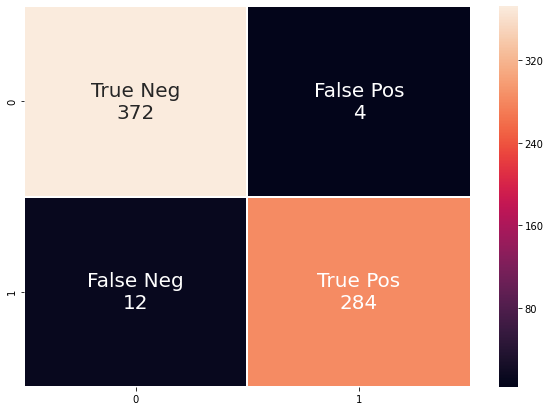

In [45]:
#confusion matrix visualization

cm_rep = confusion_matrix(tweet_rep['sentiment'],tweet_rep['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_rep.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rep,annot=labels,linewidths=1,fmt='',annot_kws={"size":20})
plt.show()


#### For Republican Party, there are only 4 false positives and 10 false negatives. The main prediction error for Republican Party is False Negative, which means the predicted sentiment is negative while the true sentiment should be positive. Thus for Republican Party, the number of supporters might be under-estimated a little bit. But Most of the data is correctly predicted.

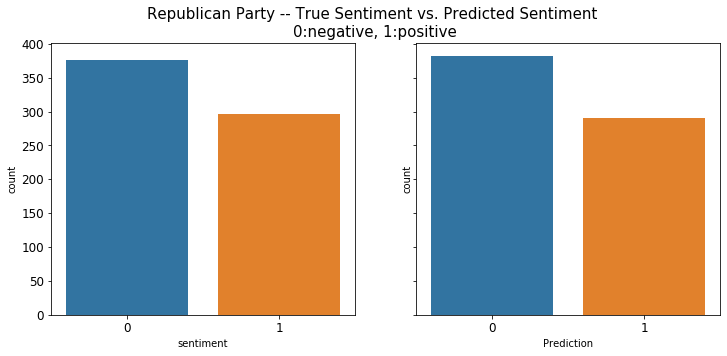

In [59]:
#histogram to see the difference between true sentiment and predicted sentiment

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Republican Party -- True Sentiment vs. Predicted Sentiment \n0:negative, 1:positive',fontsize=15)
sns.countplot(x='sentiment', data=tweet_rep,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='Prediction', data=tweet_rep,ax=ax2).tick_params(labelsize=12)

## 3.2 Difference in Sentiment Prediction Visualization for Democratic Party only

In [42]:
#accuracy
tweet_con = tweets[tweets['Party']=='Democratic Party']
acc_con = accuracy_score(tweet_con['sentiment'],tweet_con['Prediction'])
print("Accuracy of Democratic Party is: {}%".format(round(acc_con*100,2)))

Accuracy of Democratic Party is: 97.08%


In [44]:
#confusion matrix
print(confusion_matrix(tweet_con['sentiment'],tweet_con['Prediction']))

[[203  12]
 [  4 329]]


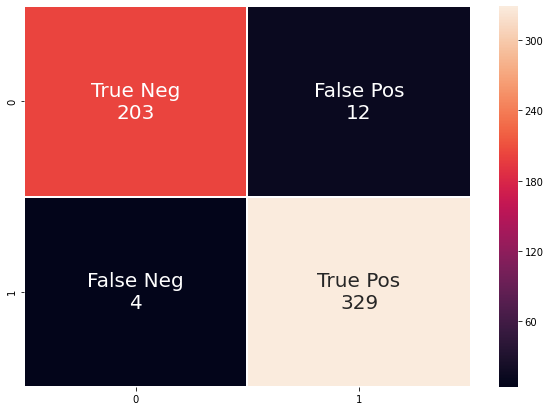

In [43]:
#confusion matrix visualization
cm_con = confusion_matrix(tweet_con['sentiment'],tweet_con['Prediction'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm_con.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(10,7))
sns.heatmap(cm_con,annot=labels,linewidths=1,fmt='',annot_kws={"size":20})

plt.show()

#### For Democratic Party, there are only 12 false positives and 4 false negatives. The main prediction error for Democratic Party is False Positve, which means the predicted sentiment is positive while the true sentiment should be negative. Thus for Democratic Party, we might over-estimate the number of supporters a little bit. But most of the data is correctly predicted.

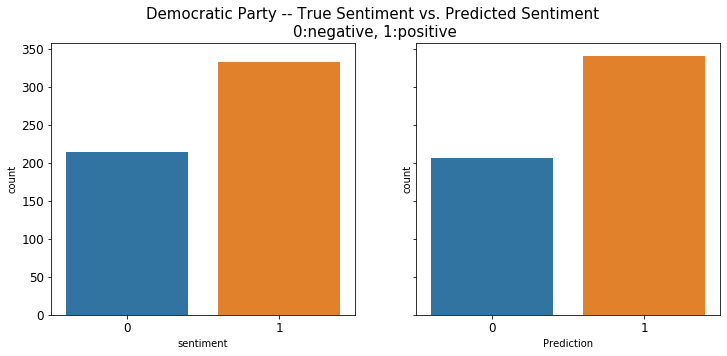

In [64]:
#histogram to see the difference between true sentiment and predicted sentiment

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,5))
fig.suptitle('Democratic Party -- True Sentiment vs. Predicted Sentiment \n0:negative, 1:positive',fontsize=15)
sns.countplot(x='sentiment', data=tweet_con,ax=ax1).tick_params(labelsize=12)
sns.countplot(x='Prediction', data=tweet_con,ax=ax2).tick_params(labelsize=12)

### **Conclusion and Discussion:** From these plots for difference bwtween true sentiment and predicted sentiment above, we can find that most of the data is correctly predicted. The first model fits so well in this dataset. Thus we can conclude that NLP analysis based on generic dataset is quite useful to predict the public attitude towards different parties. And this NLP technique can be very important for political parties during election campaigns. As we know, the election result is the Republican candidate Biden won the 2020 US election. And the result is in consistent with the sentiment distribution on twitter based on the number of supporters for different political parties. Since the NLP model predicts the sentiment distribution on twitter so well, it's a useful tool to predict which political party will win in the election. And also political parties can use it to see if they need to spend more energy and time to gain more supporters on twitter to help to win the election. 

## 4. Classifications on Negative Reasons

In [47]:
negative_tweet=tweets[tweets['sentiment']==0]
negative_tweet

,text,sentiment,negative_reason,Prediction,Party
0,robreiner afraid nov dec jan bidenharris2020 ...,0,covid19,0,Democratic Party
1,suec00k lord sumption launch recovery initiat...,0,others,0,Others
2,walidphares uber timing biden advisor pressur...,0,covid19,0,Democratic Party
5,accelerate & rise americans kill trumpvirus,0,discrimination,0,Republican Party
6,realdonaldtrump 961 dead americans day 240 ti...,0,discrimination,0,Republican Party
...,...,...,...,...,...
2542,love air watch watch news hate brainwash riot...,0,crime,0,Others
2543,euinaus challenge humanity year covid 19 faul...,0,discrimination,0,Others
2544,ty flip dump day 4 year 4 day resist maga cov...,0,covid19,1,Others
2549,donaldjtrumpjr duhnnie jr lie fox number covi...,0,covid19,0,Republican Party


In [48]:
#bag of words countvectorized already

negative_tweet=tweets[tweets['sentiment']==0]
vect=CountVectorizer(max_features=5000,token_pattern=r'\w+').fit(negative_tweet.text)
vect_=vect.transform(negative_tweet.text)

#split into training data and test data
Xn=vect_
yn=negative_tweet.negative_reason
Xn_train,Xn_test,yn_train,yn_test=train_test_split(Xn,yn,test_size=0.3,random_state=12345,stratify=negative_tweet['negative_reason'])

## 4.1 Hyperparameter Tuning by 10-fold Cross-Validation and Grid Search for Three models

### 4.1.1 Logistic Regression

### Hyperparameter Tuning by Cross-Validation and Grid Search

In [147]:
from sklearn.model_selection import GridSearchCV

parameters1 = {'C':[ 0.1, 1, 10, 100], 'solver':('liblinear','lbfgs', 'newton-cg')}

cvg_lr = LogisticRegression()
cvg1 = GridSearchCV(cvg_lr, parameters1, cv=10, n_jobs=-1)
cvg1.fit(Xn_train, yn_train)

print('The best cross-validation score: {}%'.format(round(cvg.best_score_*100,2)))
print('The best parameter:\n', cvg1.best_params_)

The best cross-validation score: 34.62%
The best parameter:
 {'C': 0.1, 'solver': 'lbfgs'}


In [50]:
cvg_lr=LogisticRegression(C=0.1,solver='liblinear').fit(Xn_train,yn_train)
train_pred1=cvg_lr.predict(Xn_train)
test_pred1=cvg_lr.predict(Xn_test)
print('Training accuracy for Logistic Regression is:{}%'.format(round(accuracy_score(yn_train,train_pred1)*100,2)))
print('Test accuracy for Logistic Regression is: {}%'.format(round(accuracy_score(yn_test,test_pred1)*100,2)))

Training accuracy for Logistic Regression is:66.86%
Test accuracy for Logistic Regression is: 36.32%


### 4.1.2 Random Forest

### Hyperparameter Tuning by Cross-Validation and Grid Search

In [145]:
parameters2 = {'max_depth':[5,10,50,100,200],'min_samples_split':[2,5,10,15,20]}

cvg_rf = RandomForestClassifier()
cvg2 = GridSearchCV(cvg_rf, parameters2, cv=10, n_jobs=-1)
cvg2.fit(Xn_train, yn_train)

print('The best cross-validation score: {}%'.format(round(cvg2.best_score_*100,2)))
print('The best parameter:\n', cvg2.best_params_)

The best cross-validation score: 35.63%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 10}


In [55]:
cvg_rf = RandomForestClassifier(max_depth=200,min_samples_split=10)
cvg_rf.fit(Xn_train,yn_train)
train_pred2=cvg_rf.predict(Xn_train)
test_pred2=cvg_rf.predict(Xn_test)
print('Training accuracy for Random Forest is:{}%'.format(round(accuracy_score(yn_train,train_pred2)*100,2)))
print('Test accuracy for Random Forest is: {}%'.format(round(accuracy_score(yn_test,test_pred2)*100,2)))

Training accuracy for Random Forest is:86.31%
Test accuracy for Random Forest is: 38.68%


### 4.1.3 SVM

### Hyperparameter Tuning by Cross-Validation and Grid Search

In [124]:
parameters3 = {'C':[0.01, 0.1, 1, 10, 100]}

cvg_svm = svm.LinearSVC()
cvg3 = GridSearchCV(cvg_svm, parameters3, cv=10, n_jobs=-1)
cvg3.fit(Xn_train, yn_train)

print('The best cross-validation score: {}%'.format(round(cvg3.best_score_*100,2)))
print('The best parameter:\n', cvg3.best_params_)

The best cross-validation score: 33.26%
The best parameter:
 {'C': 0.1}


In [56]:
cvg_svm = svm.LinearSVC(C=0.1)
cvg_svm.fit(Xn_train,yn_train)
train_pred3=cvg_svm.predict(Xn_train)
test_pred3=cvg_svm.predict(Xn_test)
print('Training accuracy for SVM is:{}%'.format(round(accuracy_score(yn_train,train_pred3)*100,2)))
print('Test accuracy for SVM is: {}%'.format(round(accuracy_score(yn_test,test_pred3)*100,2)))

Training accuracy for SVM is:98.76%
Test accuracy for SVM is: 33.95%


### Among these three models, the model using random forest has the highest test accuracy 38.68%.

## *Bonus Part 2: Visualization of the Difference Between Prediction and True Result on Negative Reason

### Random Forest Prediction on Test Dataset



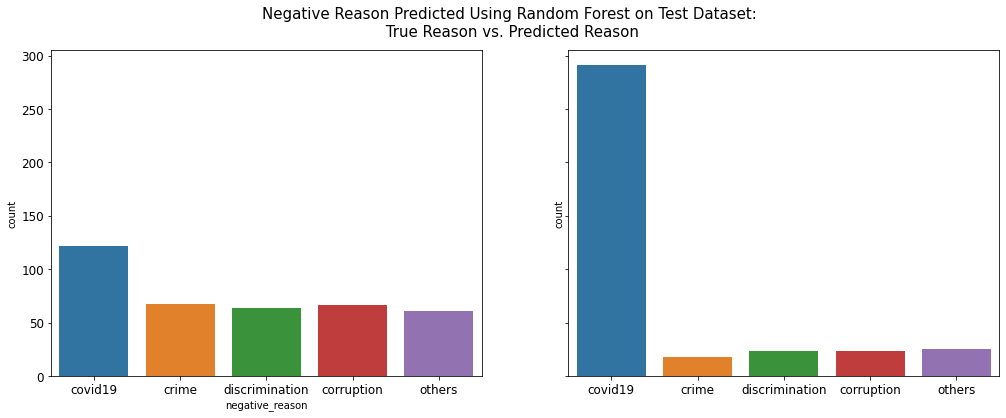

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(17,6))
fig.suptitle('Negative Reason Predicted Using Random Forest on Test Dataset:\n True Reason vs. Predicted Reason',fontsize=15)
sns.countplot(x=yn_test,ax=ax1,order=['covid19','crime','discrimination','corruption','others']).tick_params(labelsize=12)
sns.countplot(x=test_pred2, ax=ax2,order=['covid19','crime','discrimination','corruption','others']).tick_params(labelsize=12)

In [103]:
yn_test

2395        corruption
494     discrimination
2151             crime
1354             crime
219              crime
             ...      
556             others
2469        corruption
897     discrimination
2130            others
1528            others
Name: negative_reason, Length: 380, dtype: object

In [107]:
test_pred2

array(['covid19', 'covid19', 'covid19', 'covid19', 'crime', 'covid19',
       'covid19', 'covid19', 'corruption', 'covid19', 'others', 'covid19',
       'covid19', 'covid19', 'corruption', 'covid19', 'covid19',
       'covid19', 'discrimination', 'crime', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'corruption', 'covid19', 'corruption', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'discrimination', 'others', 'corruption', 'discrimination',
       'covid19', 'crime', 'corruption', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'others',
       'covid19', 'covid19', 'covid19', 'covid19', 'covid19', 'covid19',
       'covid19', 'discrimination', 'covid19', 'covid19', 'others',
       'covid19', 'covid19', 'covid19', 'others', 'corruption',
       'discrimination', 'co

### We can see that Random Forest works best since it has the highest test accuary. And from the visualized histogram above, we can see that the most wrongly predicted reason should be 'covid19'.

## *Bonus Part 3: Use N-grams Feature to Predict the Negative Reasons Using Random Forest

### N-grams BoW

In [160]:
negative_tweet=tweets[tweets['sentiment']==0]
vectn=CountVectorizer(max_features=5000,ngram_range=(1,2),token_pattern=r'\w+').fit(negative_tweet.text)
vectn_=vect.transform(negative_tweet.text)

In [161]:
#split into training data and test data
nXn=vectn_
nyn=negative_tweet.negative_reason
nXn_train,nXn_test,nyn_train,nyn_test=train_test_split(nXn,nyn,test_size=0.3,random_state=12345,stratify=negative_tweet['negative_reason'])

In [162]:
#hyperparameter tuning
parameters2 = {'max_depth':[5,10,50,100,200],'min_samples_split':[2,5,10,15,20]}         

cvg_rf2 = RandomForestClassifier()
cvg2 = GridSearchCV(cvg_rf2, parameters2, cv=10, n_jobs=-1)
cvg2.fit(Xn_train, yn_train)

print('The best cross-validation score: {}%'.format(round(cvg2.best_score_*100,2)))
print('The best parameter:\n', cvg2.best_params_)

The best cross-validation score: 35.52%
The best parameter:
 {'max_depth': 200, 'min_samples_split': 5}


In [163]:
cvg_rf2 = RandomForestClassifier(max_depth=200,min_samples_split=5)
cvg_rf2.fit(Xn_train,yn_train)
train_pred4=cvg_rf2.predict(Xn_train)
test_pred4=cvg_rf2.predict(Xn_test)
print('Training accuracy for Random Forest is:{}%'.format(round(accuracy_score(yn_train,train_pred4)*100,2)))
print('Test accuracy for Random Forest is: {}%'.format(round(accuracy_score(yn_test,test_pred4)*100,2)))

Training accuracy for Random Forest is:57.01%
Test accuracy for Random Forest is: 35.79%


### Using N-grams features, the test accuracy is still lower than just using BoW feature for Random Forest model. But it's a good try.

## *Bonus Part 4: Using Multilayer Perceptron Neural Network to Predict Negative Reasons

### Cross-Validation

In [118]:
from sklearn.neural_network import MLPClassifier


nr_mlp = MLPClassifier()
parameters = {'activation':['logistic', 'relu','tanh'],'alpha':[0.001,0.01,0.1,0.5,1],'learning_rate':['adaptive','constant', 'invscaling']}
mlp = GridSearchCV(nr_mlp, parameters, cv=10, n_jobs=-1)
mlp.fit(Xn_train, yn_train)

print('The best cross-validation score: {}%'.format(round(mlp.best_score_*100,2)))
print('The best parameter:\n', mlp.best_params_)

The best cross-validation score: 34.05%
The best parameter:
 {'activation': 'logistic', 'alpha': 0.5, 'learning_rate': 'adaptive'}


### Hyperparameter Tuning

In [168]:
nr_mlp = MLPClassifier(activation='logistic',alpha=0.5,learning_rate='adaptive')
nr_mlp.fit(Xn_train, yn_train)
train_pred5 = nr_mlp.predict(Xn_train)
test_pred5=nr_mlp.predict(Xn_test)
print('Training accuracy for Multilayer Perceptron is:{}%'.format(round(accuracy_score(yn_train,train_pred5)*100,2)))
print('Test accuracy for Multilayer Perceptron is: {}%'.format(round(accuracy_score(yn_test,test_pred5)*100,2)))

Training accuracy for Multilayer Perceptron is:88.69%
Test accuracy for Multilayer Perceptron is: 38.68%


### The test accuracy is almost the same as the best model we get above, but we cannot see obvious improvements in accuracy.

# Part 5. Discussion

### For Political Affiliations of the tweets:

### Describe the results of the analysis and discuss your interpretation of the results.
>- From the frequency distribution of political party plot, we can find there are more tweets relevant to Republican Party. While by comparing the sentiment distribution for different political parties, we can see for Republican Party, there are much more negative tweets than positive ones. And for Democratic Party, the number of positive tweets is much higher than that of negative ones.
>- From the word cloud visualization for two political parties, we can see that for Republican Party, many negative words such as 'die', 'lose', 'death', 'fail', 'lie', 'trumpcrimefamily' and so on have bigger size which means they appear frequently on twitter. While for Democratic Party, the frequency of negative words is much less than that of positive words. To be specific, there are many obvious positive words such as  'love','good','win','support' and so on.
>- The accuracy of applying the first model to US_Election_2020 dataset is very high , which is 97.8056%. Thus the prediction matches the sentiment labelled in the 2020 US election data very well.
>- From the confusion matrix and visualization of difference between true sentiment and predicted sentiment with histogram, we can see the most of the data is correctly predicted. For Republican Party, there are only 4 false positives and 10 false negatives. The main prediction error for Republican Party is False Negative, which means the predicted sentiment is negative while the true sentiment should be positive. Thus for Republican Party, the number of supporters might be under-estimated a little bit. While for Democratic Party, there are only 12 false positives and 4 false negatives. The main prediction error for Democratic Party is False Positve, which means the predicted sentiment is positive while the true sentiment should be negative. Thus for Democratic Party, the number of supporters might be over-estimated a little bit. But most of the data is correctly predicted.

### Explain how each party is viewed in the public eye based on the sentiment value.
>- From the count plot of sentiment value for different political affiliations of the tweets, we can see that for Democratic Party,there are much more positive tweets than negative ones. While for Republican Party, the number of negative tweets are far more than positive ones. Thus, from the data of twitter, more people hold positive opinions about Democratic Party, compared to the Republican Party.

### For the Second Model to Predict Negative Reasons:

### For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons.

>- **The model that worked best is the random forest model with max_depth equal to 200, min_samples_split equal to 10 using Bag of Word feature. The test accuracy is 38.68%. The reasons why the model may fail to predict the correct negative reasons are as below.**
>- **1.** Overfitting may exist since there are 5000 features, while the number of datapoints in the US Election dataset with negative reason is only 2552. And also when the traning accuracy is much higher than test accuracy, there always exists overfitting.
>- **2.** The size of the dataset is too small compared to that of the sentiment_analysis dataset, especially for multi-classification problem.

### Back up your reasoning with examples from the test sets. 

>- **1.** For this part, all three models I trained have much higher training accuracy than test accuracy. For example, the training accuracy for Random Forest is:86.31%, far more than the accuracy of testset with 38.68%.
>- **2.** For example, the true negative reason of the data point 2395 is 'corruption', while its predicted reason is 'covid19'. This situation occurs probably because the number of datapoints with the reason 'corruption' is too small (less than 75), the reason 'covid 19' occupies the most part of the dataset.

### For both models, suggest one way you can improve the accuracy of your models.

>- **1.For the first model:** Since I only selected 20% of the whole dataset, it might be better if I can randomly choose more datapoints like 30% or 50%.
>- **2.For the second model:** The accuracy of the model can be improved if I can reduce the number of the features. i.e.,reduce 5000 features to 3000 features.

### Answer research questions above:

>- **1.How well do your predictions match the sentiment labelled in the 2020 US elections data?**
>-  The accuracy of applying the first model to US_Election_2020 dataset is very high , which is 97.8056%. Thus the prediction matches the sentiment labelled in the 2020 US election data very well.
And from the confusion matrix and visualization of difference between true sentiment and predicted sentiment with histogram, we can see the most of the data is correctly predicted. For Republican Party, there are only 4 false positives and 10 false negatives. The main prediction error for Republican Party is False Negative, which means the predicted sentiment is negative while the true sentiment should be positive. Thus for Republican Party, the number of supporters might be under-estimated a little bit. While for Democratic Party, there are only 12 false positives and 4 false negatives. The main prediction error for Democratic Party is False Positve, which means the predicted sentiment is positive while the true sentiment should be negative. Thus for Democratic Party, the number of supporters might be over-estimated a little bit. But most of the data is correctly predicted.

>- **2.Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.**
>- From these plots for difference bwtween true sentiment and predicted sentiment above, we can find that most of the data is correctly predicted. The first model fits so well in this dataset. Thus we can conclude that NLP analysis based on generic dataset is quite useful to predict the public attitude towards different parties. And this NLP technique can be very important for political parties during election campaigns. As we know, the election result is the Republican candidate Biden won the 2020 US election. And the result is in consistent with the sentiment distribution on twitter based on the number of supporters for different political parties. Since the NLP model predicts the sentiment distribution on twitter so well, it's a useful tool to predict which political party will win in the election. And also political parties can use it to see if they need to spend more energy and time to gain more supporters on twitter to help to win the election.